In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.optimize as scopt
import cvxpy

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 49.99999999999978


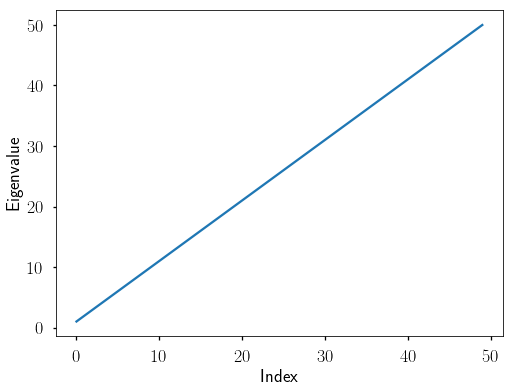

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(2e-2))
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Function value = -2.571866353027874
Norm of gradient = 0.018952535964413063
	 Newton
Convergence in 1 iterations
Function value = -2.5719498841589
Norm of gradient = 5.215989809471608e-14
	 CG quad
Convergence in 37 iterations
Function value = -2.571949884158893
Norm of gradient = 4.818310479962166e-07
	 CG FR
Convergence in 75 iterations
Function value = -2.571949884158828
Norm of gradient = 9.971658336799657e-07
	 BB 1
Convergence in 78 iterations
Function value = -2.5719498841588626
Norm of gradient = 4.441549267772047e-07
	 Nesterov
Convergence in 100 iterations
Function value = -2.571949746664809
Norm of gradient = 0.0005426242459758335


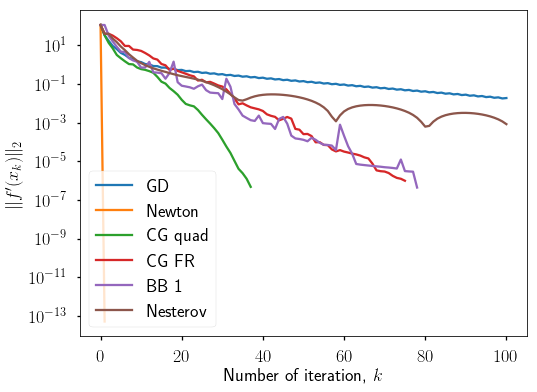

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [8]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
1.78 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Newton
61.8 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
763 µs ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG FR
5.79 ms ± 398 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.27 ms ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.89 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000005726


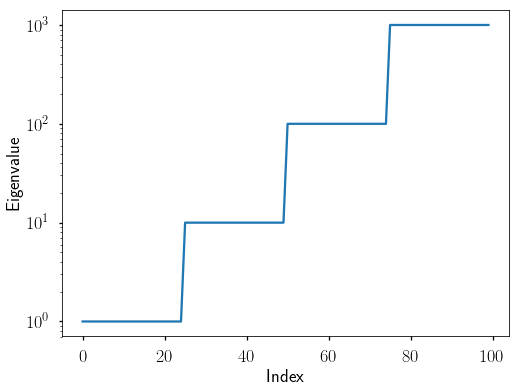

In [8]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [9]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [10]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3))
    }

In [11]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [12]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Function value = -4.025296873008534
Norm of gradient = 17.050956990235896
	 Newton
Convergence in 1 iterations
Function value = -18.219027413635086
Norm of gradient = 1.415787848314251e-12
	 CG quad
Convergence in 4 iterations
Function value = -18.219027413635228
Norm of gradient = 6.101485390250203e-07
	 CG FR
Convergence in 100 iterations
Function value = -18.06861389213126
Norm of gradient = 0.5605609864159344
	 BB 1
Convergence in 73 iterations
Function value = -18.21902741363514
Norm of gradient = 4.870019766703323e-07
	 Nesterov
Convergence in 100 iterations
Function value = -12.991155422011246
Norm of gradient = 3.2402897805103943


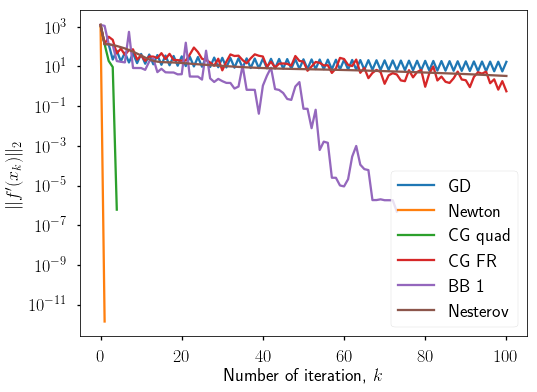

In [13]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [15]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
2.73 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
159 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
112 µs ± 5.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG FR
19.6 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
1.82 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
2.69 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Analytical center of the set of inequalities

In [2]:
n = 3000
m = 100
A = np.random.rand(m, n) * 10

In [3]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) \
                           + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.T / (1 - A.dot(x))**2).dot(A) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

class hess_matvec(object):
    def __init__(self, x):
        self._x = x
    
    def dot(self, y):
        d_part = y * 2 * (1 + self._x**2) / (1 - self._x**2)**2
        m_part = (A.T / (1 - A.dot(self._x))**2).dot(A.dot(y))
        return m_part + d_part

In [4]:
m_dict = {
     "GD Armijo": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3)),
     "Inexact Newton": solvers.so.InexactNewtonMethod(f, grad_f, hess_matvec, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "GD Lipschitz": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.))
    }

In [5]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD Armijo


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 10 iterations
Function value = -706.6532142161633
Norm of gradient = 4.823369721535737e-07
	 Newton
Convergence in 14 iterations
Function value = -706.6532142161631
Norm of gradient = 1.5221648362029882e-06
	 CG FR
Convergence in 17 iterations
Function value = -706.6532142161562
Norm of gradient = 5.819296515235466e-06
	 BB 1
Convergence in 10 iterations
Function value = -706.6532142161597
Norm of gradient = 5.358846631423611e-06
	 Nesterov
Convergence in 100 iterations
Function value = -704.3818427844329
Norm of gradient = 4.565344848035749
	 Inexact Newton
Convergence in 20 iterations
Function value = -706.6532142161609
Norm of gradient = 4.0233273556416125e-06
	 GD Lipschitz
Convergence in 24 iterations
Function value = -706.6532142161486
Norm of gradient = 7.868324659666723e-06


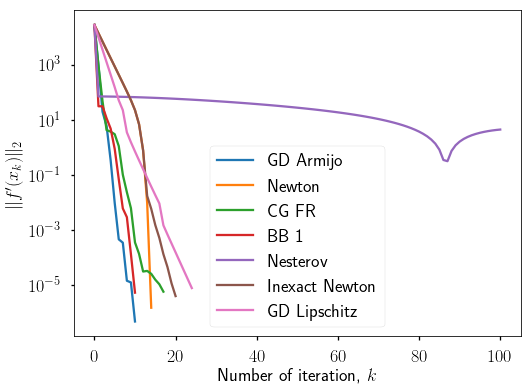

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [126]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


23.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
3.79 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 CG FR


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


54.1 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
17.2 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
124 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Inexact Newton
81.3 ms ± 8.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Toy logistic regression with L2 regularization

In [8]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 1.84988747172205


In [9]:
m_dict = {
     "GD Armijo": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-2)),
     "GD Lipschitz": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.))
    }

In [10]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [11]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD Armijo
Convergence in 100 iterations
Function value = 0.48555662479538253
Norm of gradient = 0.0003989566126940712
	 Newton
Convergence in 37 iterations
Function value = 0.4855565678421959
Norm of gradient = 8.301122015720936e-06
	 CG FR
Convergence in 49 iterations
Function value = 0.48555656785697415
Norm of gradient = 7.93915746566523e-06
	 BB 1
Convergence in 47 iterations
Function value = 0.4855565678466114
Norm of gradient = 3.881426346731685e-06
	 Nesterov
Convergence in 100 iterations
Function value = 0.4855567808099111
Norm of gradient = 0.0008331285851383981
	 GD Lipschitz
Convergence in 100 iterations
Function value = 0.4855565855667607
Norm of gradient = 0.0003015313607805513


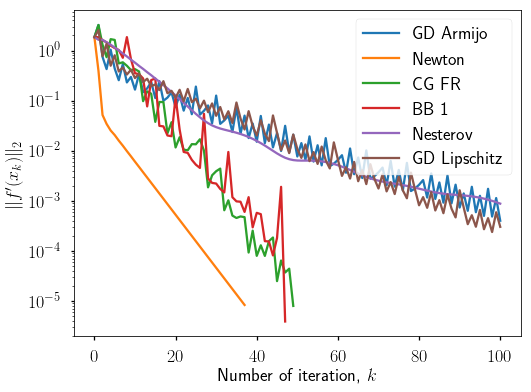

In [12]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [28]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
94.5 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
47.1 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 CG FR
52.2 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
7.22 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
14 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Non-smooth optimization
### Toy SVM classifier

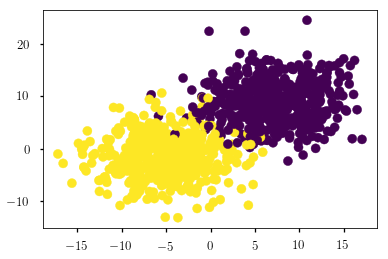

In [13]:
import sklearn.datasets as skldata
n = 2
m = 1000
C = 1
X, y = skldata.make_blobs(n_features=n, n_samples=m, centers=2, cluster_std=4)
y = 2 * y - 1
plt.scatter(X[:, 0], X[:, 1], c=y)

### CVXPy solver

In [14]:
tol = 1e-5
max_iter = 300

In [15]:
w = cvxpy.Variable(n)
b = cvxpy.Variable()
obj = 0.5 * cvxpy.norm2(w)**2 + C * cvxpy.sum_entries(cvxpy.max_elemwise(0, 1 - cvxpy.mul_elemwise(y, (X * w - b))))
problem = cvxpy.Problem(cvxpy.Minimize(obj))
problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
b = b.value
w = np.array(w.value)
print("Optimal objective = {}".format(obj.value))
print("Train accuracy = {}".format(np.mean(y == np.sign(X.dot(w) - b).ravel())))

Optimal objective = 62.02700530634681
Train accuracy = 0.976


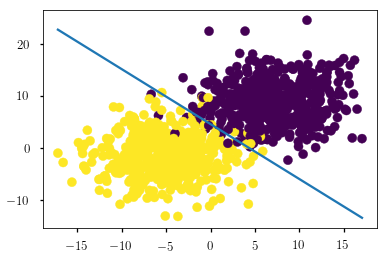

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y)
x = np.linspace(min(X[:, 0]), max(X[:, 0]))
plt.plot(x, (b - w[0] * x) / w[1])

In [17]:
def hinge_loss(w, X, y, C):
    return 0.5 * np.linalg.norm(w)**2 + C * np.sum(np.maximum(0, 1 - y * X.dot(w)))

def subgrad_hinge_loss(w, X, y, C):
    nnz = 1 - y * X.dot(w)
    subgrad_part = X * y[:, np.newaxis]
    return w - C * np.sum(subgrad_part[nnz > 0], axis=0)

X_ones = np.hstack((X, np.ones((m, 1))))
f = lambda x: hinge_loss(x, X_ones, y, C)
subgrad = lambda x: subgrad_hinge_loss(x, X_ones, y, C)

In [18]:
m_dict = {"Subgrad method": solvers.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
          "Dual averaging": solvers.fo.DualAveraging(f, subgrad, ss.InvIterStepSize(), ss.ScaledConstantStepSize(1.0)),
          "SM L": solvers.fo.SubgradientMethod(f, subgrad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, eps=1e-3, init_alpha=1))
         }

In [19]:
x0 = np.random.randn(n+1)

In [20]:
for key in m_dict:
    print("\t {}".format(key))
    x = m_dict[key].solve(x0, max_iter, tol, disp=True)
    print("Train accuracy = {}".format(np.mean(y == np.sign(X_ones.dot(x)))))

	 Subgrad method
Convergence in 300 iterations
Function value = 88.27169116732259
Train accuracy = 0.971
	 Dual averaging
Convergence in 300 iterations
Function value = 150.03304077225243
Norm of gradient = 508.7595564040112
Train accuracy = 0.944
	 SM L
Convergence in 300 iterations
Function value = 64.17182907897356
Train accuracy = 0.975


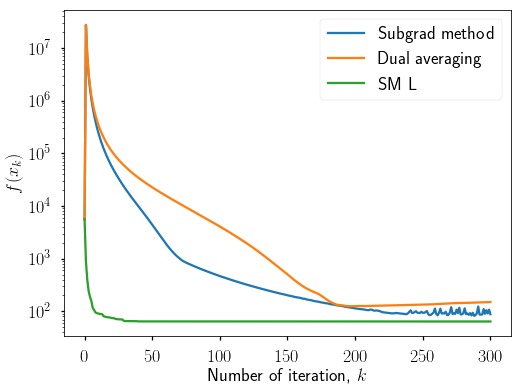

In [21]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([f(x) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [38]:
print("\t SCS CVXPy")
%timeit problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 SCS CVXPy
49.2 ms ± 6.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Subgrad method
12.9 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Dual averaging
31.2 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
